### Collision rate

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene
from mapsgan.evaluation import Visualization
from mapsgan.sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os

model_path = '../models/cloud/'
os.listdir(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bicy_enc_1_20190117-134649_epoch_10000',
 'bicy_weights_1_20190117-155010_epoch_10000',
 'bicy_weights_2_20190118-073226_epoch_70000',
 'bicy_weights__encoptim_3_20190118-124310_epoch_10000',
 'clr_1_20190114-160949_epoch_10000',
 'cvae_1_20190114-154818_epoch_10000',
 'eth_12_model.pt',
 'sgan_1_20190117-055507_epoch_10000',
 'toymodel_1_20190117-172104_epoch_10000']

In [2]:
in_len, out_len = 8, 12
sgangenerator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

toygenerator = ToyGenerator(in_len=in_len, out_len=out_len)
toydiscriminator = ToyDiscriminator()

bicyclegenerator = BicycleGenerator(ToyGenerator, start_mode='cvae')

In [3]:
models = {'Baseline':{'generator': toygenerator, 'ckpt': 'toymodel_1_20190117-172104_epoch_10000'},
          'cLR':{'generator': bicyclegenerator, 'ckpt': 'clr_1_20190114-160949_epoch_10000'},
          'cVAE':{'generator': bicyclegenerator, 'ckpt': 'cvae_1_20190114-154818_epoch_10000'},
          'Bicycle':{'generator': bicyclegenerator, 'ckpt': 'bicy_weights_1_20190117-155010_epoch_10000'},
          'SGAN':{'generator': sgangenerator, 'ckpt':'sgan_1_20190117-055507_epoch_10000'},
          'cLRSGAN':{'generator': None, 'ckpt': ''},
          'cVAESGAN':{'generator': None, 'ckpt': ''},
          'BicycleSGAN':{'generator': None, 'ckpt': ''}}

In [7]:
def get_model_solver(key, models, solver=BaseSolver):
    solver = solver(ToyGenerator(in_len=in_len, out_len=out_len), ToyDiscriminator()) # dummies
    solver.generator = models[key]['generator']
    solver.load_generator(model_path + models[key]['ckpt'])
    return solver

In [8]:
solver = get_model_solver('SGAN', models)

In [4]:
from attrdict import AttrDict
checkpoint = torch.load(model_path + 'eth_12_model.pt', map_location='cpu')
args = AttrDict(checkpoint['args'])
generator = TrajectoryGenerator(
    obs_len=args.obs_len,
    pred_len=args.pred_len,
    embedding_dim=args.embedding_dim,
    encoder_h_dim=args.encoder_h_dim_g,
    decoder_h_dim=args.decoder_h_dim_g,
    mlp_dim=args.mlp_dim,
    num_layers=args.num_layers,
    noise_dim=args.noise_dim,
    noise_type=args.noise_type,
    noise_mix_type=args.noise_mix_type,
    pooling_type=args.pooling_type,
    pool_every_timestep=args.pool_every_timestep,
    dropout=args.dropout,
    bottleneck_dim=args.bottleneck_dim,
    neighborhood_size=args.neighborhood_size,
    grid_size=args.grid_size,
    batch_norm=args.batch_norm)
generator.load_state_dict(checkpoint['g_state'])
solver = BaseSolver(ToyGenerator(in_len=in_len, out_len=out_len), ToyDiscriminator())
solver.generator = generator

In [5]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, testloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

In [6]:
output = solver.test(testloader)

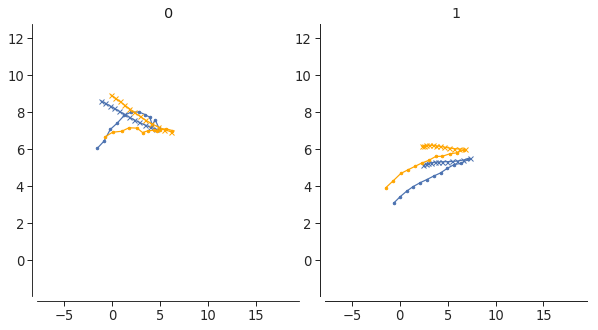

In [7]:
vis = Visualization()
vis.trajectories(output, [0, 1], ground_truth=True, )

### Collision rate

In [42]:
def get_collisions(output, thresh=0.5):
    """Computes collision on array of (seq_len, num_agents, num_chords)"""
    from scipy.spatial.distance import pdist, squareform
    collisions = 0
    xy_pred = output['xy_pred']
    for scene in xy_pred:
        for i, step in enumerate(xy):
            dm = squareform(pdist(step))  # step is (num_agents, dimensions xy) 
            ind = np.triu_indices(dm.shape[0], k=1)
            for distance in dm[ind]:
                if distance < thresh:
                    collisions += 1
    return collisions

In [45]:
get_collisions(output, thresh=0.5)

48

### Final displacement error

In [101]:
pred = output['xy_pred']
gt = output['xy_out']

In [102]:
def get_collisions(output, thresh=0.5):
    """Computes collision on array of (seq_len, num_agents, num_chords)"""
    from scipy.spatial.distance import pdist, squareform
    collisions = 0
    xy_pred = output['xy_pred']
    for scene in xy_pred:
        for i, step in enumerate(xy):
            dm = squareform(pdist(step))  # step is (num_agents, dimensions xy) 
            ind = np.triu_indices(dm.shape[0], k=1)
            for distance in dm[ind]:
                if distance < thresh:
                    collisions += 1
    return collisions

def get_average_fde(output):
    pred = output['xy_pred']
    gt = output['xy_out']
    diff = 0
    for i, scene in enumerate(pred):
        last_p = scene[-1]
        last_gt = gt[i][-1]
        diff += np.linalg.norm((last_p-last_gt), axis=1).mean()
    diff /= len(pred)
    return diff
    

In [103]:
average_fde(output)

35.91936370304653